In [1]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.palettes import Spectral6
from bokeh.transform import factor_cmap
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool
from bokeh.models import CategoricalColorMapper
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import create_plots
import pickle
from wordcloud import WordCloud
from itertools import chain
import random
import matplotlib.pyplot as plt

In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
#thomann_data = pd.read_csv("C:/Users/jonas/thomann/additional_thomann_data.csv")
thomann_data = pd.read_csv("thomann_reviews_all.csv")

In [4]:
thomann_data.head(1)

author   categorie                          guitar  \
0   Thomas881, 07.05.2016   E-Gitarren  Ibanez RGAIX7FM-TGF Iron Label   

          guitar_type                                       key_features  \
0   7-Saiter Gitarren  {'Farbe': 'Grau', 'Korpus': 'Mahagoni', 'Decke...   

  manufacturer  price                                             review  \
0       Ibanez  785 €   Handling: Die Gitarre ist schön leicht und lä...   

   stars_features  stars_gesamt  stars_sound  stars_verarbeitung  
0            80.0           100        100.0                80.0

### Ursprungskategorien der gecrawlten Reviews

Einzelne Gitarrentypen sind unterschiedlich beliebt. Daraus resultieren unterschiedlichen Mengen an Reviews je nach Kategorie. Der folgende Plot soll zeigen wie die Reviews über die Kategorien verteilt sind.

In [5]:
plot_data = thomann_data.groupby(['categorie','guitar_type'])['guitar'].count().reset_index()
plot_data.guitar_type = plot_data.guitar_type.astype(str) 
source = ColumnDataSource(plot_data)
index_cmap = factor_cmap('categorie', palette=Spectral6, factors=sorted(plot_data.categorie.unique()), end=1)
size = len(thomann_data)
p = figure(plot_width=1000,x_range = plot_data['guitar_type'], title = "Einordnung der gecrawlten Reviews (n=%s)"%size, 
           tooltips=[('Kategorie',"@guitar_type:"),('Wert',"@guitar")])
p.vbar(x="guitar_type",top="guitar", width=1, source=source, line_color="white", fill_color=index_cmap, legend="categorie")
p.xaxis.major_label_orientation = 1.4
p.xaxis.axis_label = None
p.yaxis.axis_label = "Anzahl"
p.outline_line_color = None
p.legend.orientation = "vertical"
p.legend.location ="top_left"
show(p)

### Unbalancierte Daten

die gecrawlten Daten weißen eine Schiefe auf. Gute Reviews sind sehr viel häufiger als negative was sich später auf die Vorhersage auswirken wird.

In [6]:
thomann_data.stars_gesamt.value_counts()

100    10669
80      5282
60      1331
40       443
20       208
Name: stars_gesamt, dtype: int64

### kumulierte Verteilungsfunktion

hier wird untersucht wo die Bewertungen herkommen bzw. ob es evlt. nur wenige Produkte gibt, die den meisten Teil an insgesamten Bewertungen ausmachen. 

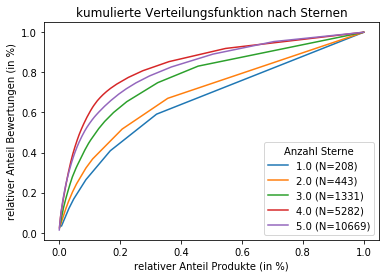

In [7]:
stars_list = []
y_list = []
x_list = []
N_reviews_list = []
N_product_list = []


for i in np.unique(thomann_data["stars_gesamt"]):
    data = thomann_data[thomann_data["stars_gesamt"]==i]
    # wieviele bewertungen gibt es pro Produkt?
    y = list(nltk.FreqDist(data["guitar"]).values())
    y.sort(reverse=True)
    # relativer anteil
    y = [a/data.shape[0] for a in y]
    y = np.cumsum(y)
    x = np.arange(1,len(y)+1)
    x = [a/len(x) for a in x]
    stars_list.append(i)
    y_list.append(y)
    x_list.append(x)
    N_reviews_list.append(data.shape[0])
    N_product_list.append(len(x))
    
fig, ax = plt.subplots()
for x, y, star, N in zip(x_list, y_list, stars_list, N_reviews_list):
    ax.plot(x, y, label = "{} (N={})".format(star/20, N))
plt.legend(title="Anzahl Sterne")
plt.xlabel("relativer Anteil Produkte (in %)")
plt.ylabel("relativer Anteil Bewertungen (in %)")
plt.title("kumulierte Verteilungsfunktion nach Sternen")
plt.savefig('kumuVert.pdf')

### Analyse nach Preprocessing

In [8]:
# open dataset 
# muss erst entpackt werden!
with open('modelling/enriched_thomann_data.pickle', 'rb') as f:
        thomann_data = pickle.load(f)

In [9]:
thomann_data.head(1)

author   categorie                          guitar  \
0   Thomas881, 07.05.2016   E-Gitarren  Ibanez RGAIX7FM-TGF Iron Label   

          guitar_type                                       key_features  \
0   7-Saiter Gitarren  {'Farbe': 'Grau', 'Korpus': 'Mahagoni', 'Decke...   

  manufacturer  price                                             review  \
0       Ibanez  785 €  handling gitarr schon leicht lasst toll bespie...   

   stars_features  stars_gesamt  stars_sound  stars_verarbeitung  \
0            80.0           100        100.0                80.0   

                                          review_old  \
0   Handling: Die Gitarre ist schön leicht und lä...   

                                         taggedWords  \
0  [(Handling, NN), (Die, DT), (Gitarre, NN), (is...   

                            replace_negations_bigram  \
0  [(nicht perfekt, nicht NOT_perfekt), (kein Zuf...   

  replace_negations_trigram  \
0                        []   

                                     taggedWords_neg  \
0  [(Handling, NN), (Die, DT), (Gitarre, NN), (is...   

                                    tokenSent_pp_neg  \
0  [handling gitarr schon leicht lasst toll bespi...   

                                      review_pp_only  \
0  handling gitarr schon leicht lasst toll bespie...   

                                    tokenWord_pp_neg  
0  [handling, gitarr, schon, leicht, lasst, toll,...

### dist_word()

mit dieser Funktion kann sich die relative Verteilung für ein Wort über die Bewertungsklassen angeschaut werden. Dadurch kann man identifizieren in welcher Klasse ein Wort, relativ gesehen, am Häufigsten vorkommt.

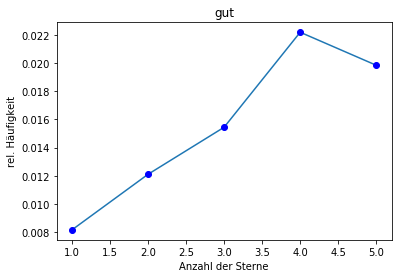

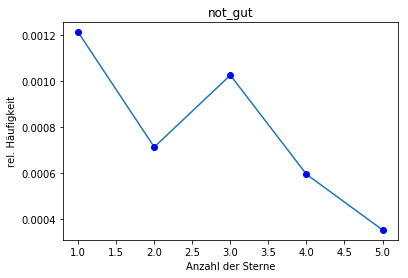

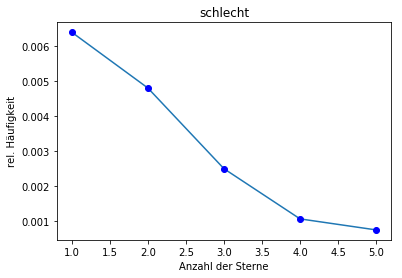

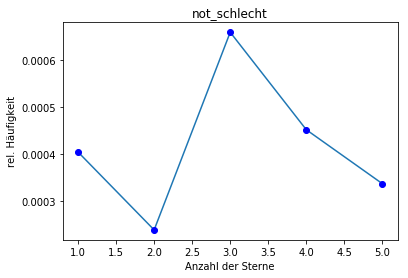

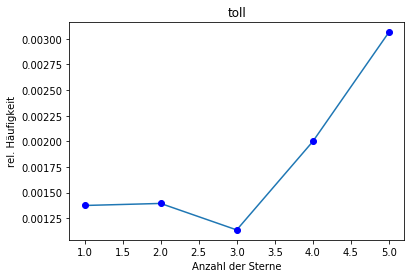

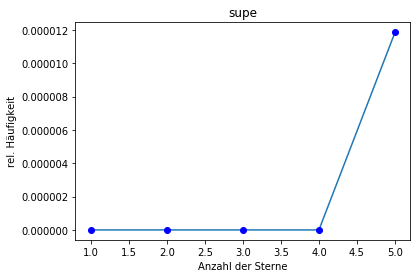

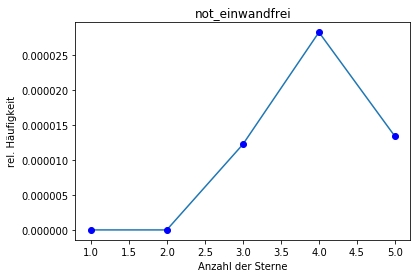

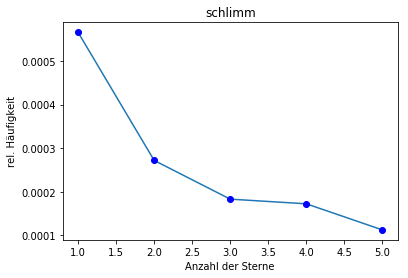

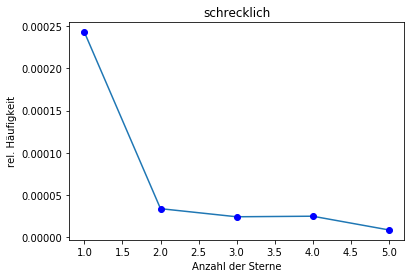

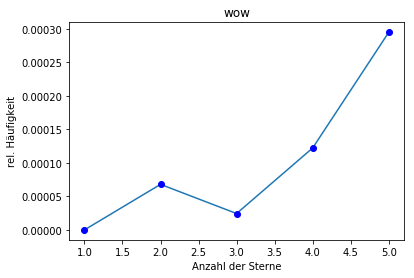

In [10]:
for word in ["gut","not_gut","schlecht","not_schlecht","toll","supe","not_einwandfrei","schlimm","schrecklich","wow"]:
    create_plots.dist_word(word,thomann_data)

### bigram_wordcloud()

mithilfe dieser Funktion ist möglich sich bigrams für eine Kategorie anzusehen. So kann man mit den `pos1` und `pos2` Parametern bestimmen um welche Wortart es sich handeln soll und mit den `word1` und `word2` Parametern um welches konkrete Wort. Die Parameter lassen die Angabe in regex zu sodass auch komplizierte Abfragen zugelassen werden.

#### Was sind häufige Adjektiv-Nomen Paare

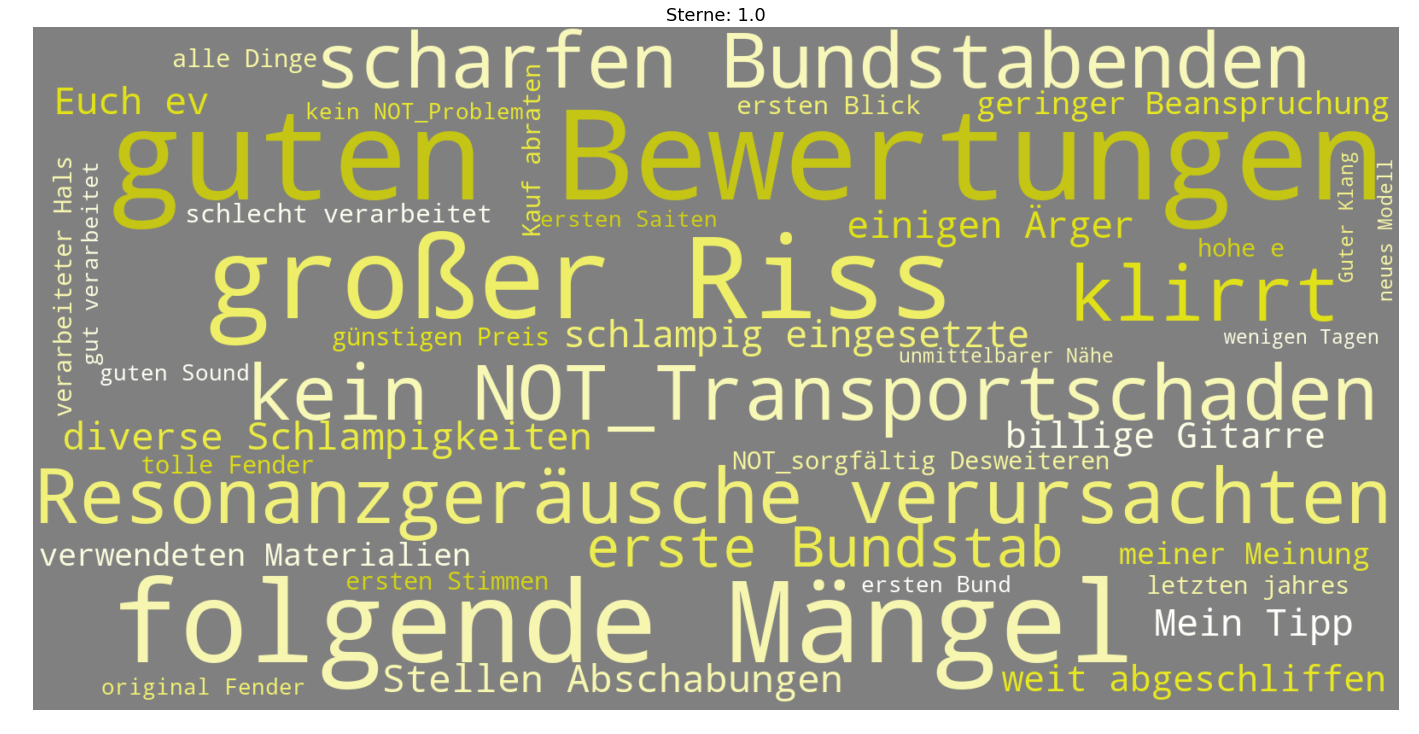

<Figure size 432x288 with 0 Axes>

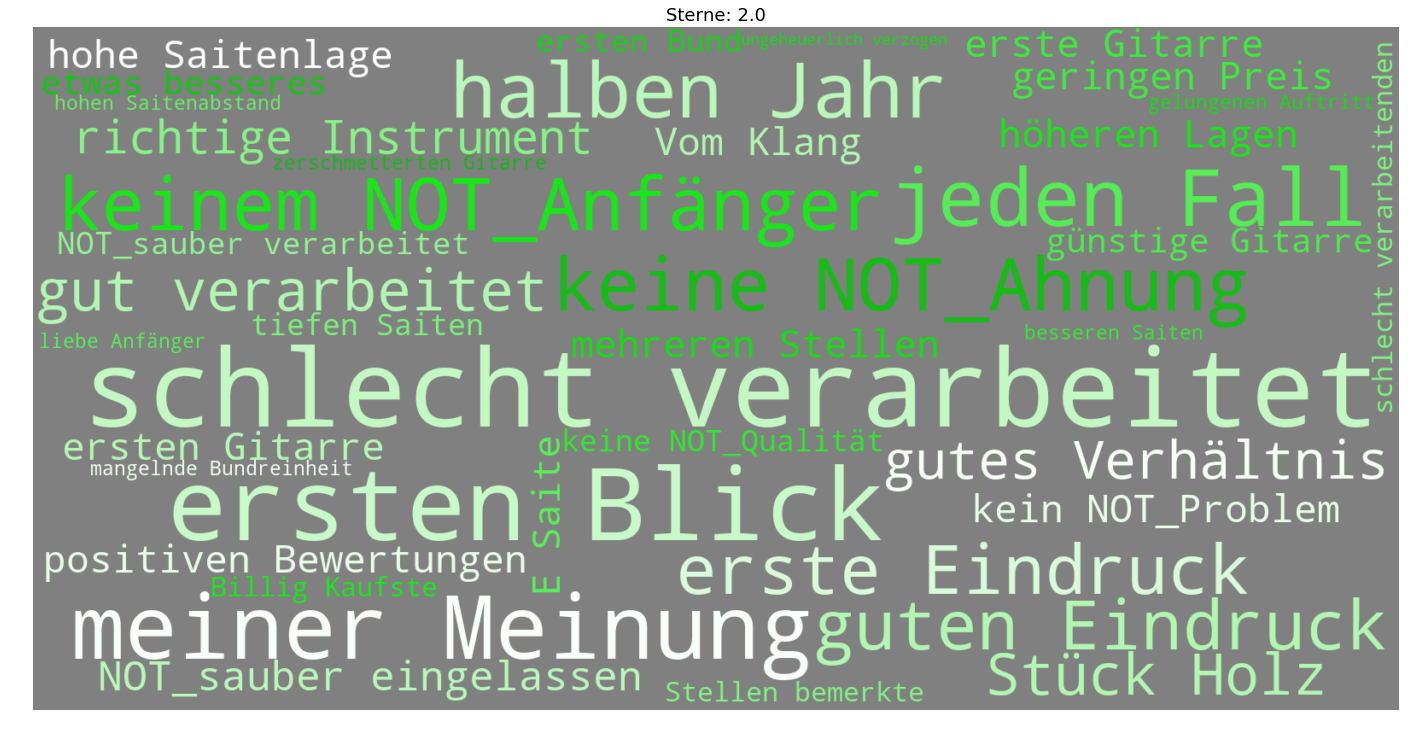

<Figure size 432x288 with 0 Axes>

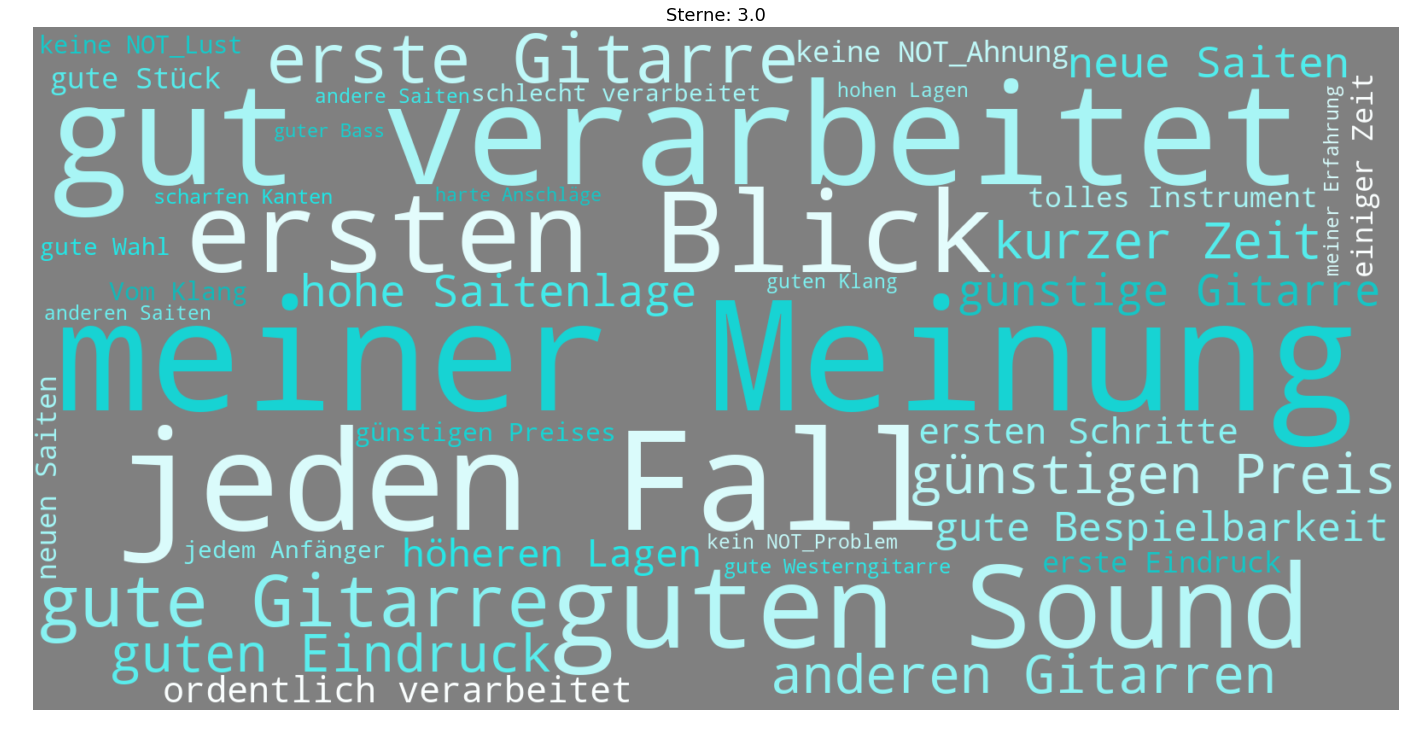

<Figure size 432x288 with 0 Axes>

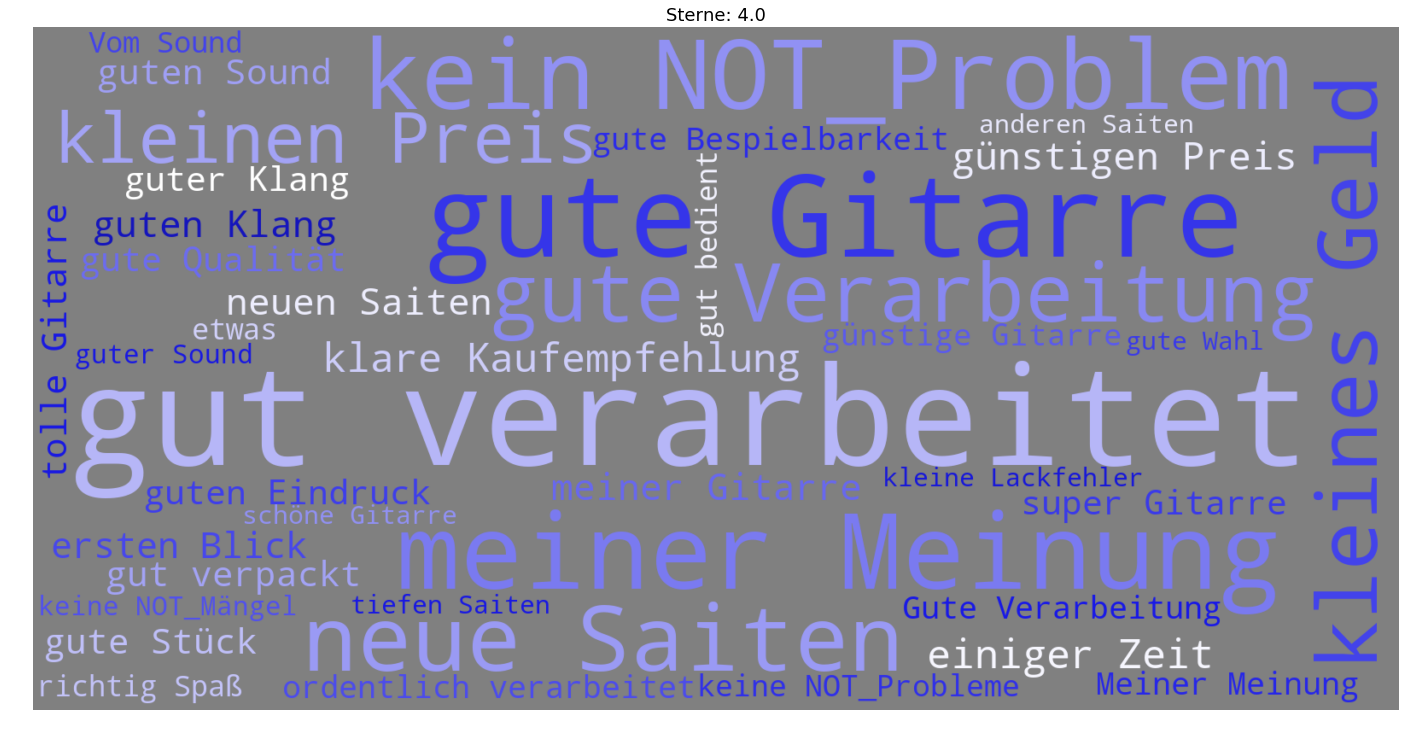

<Figure size 432x288 with 0 Axes>

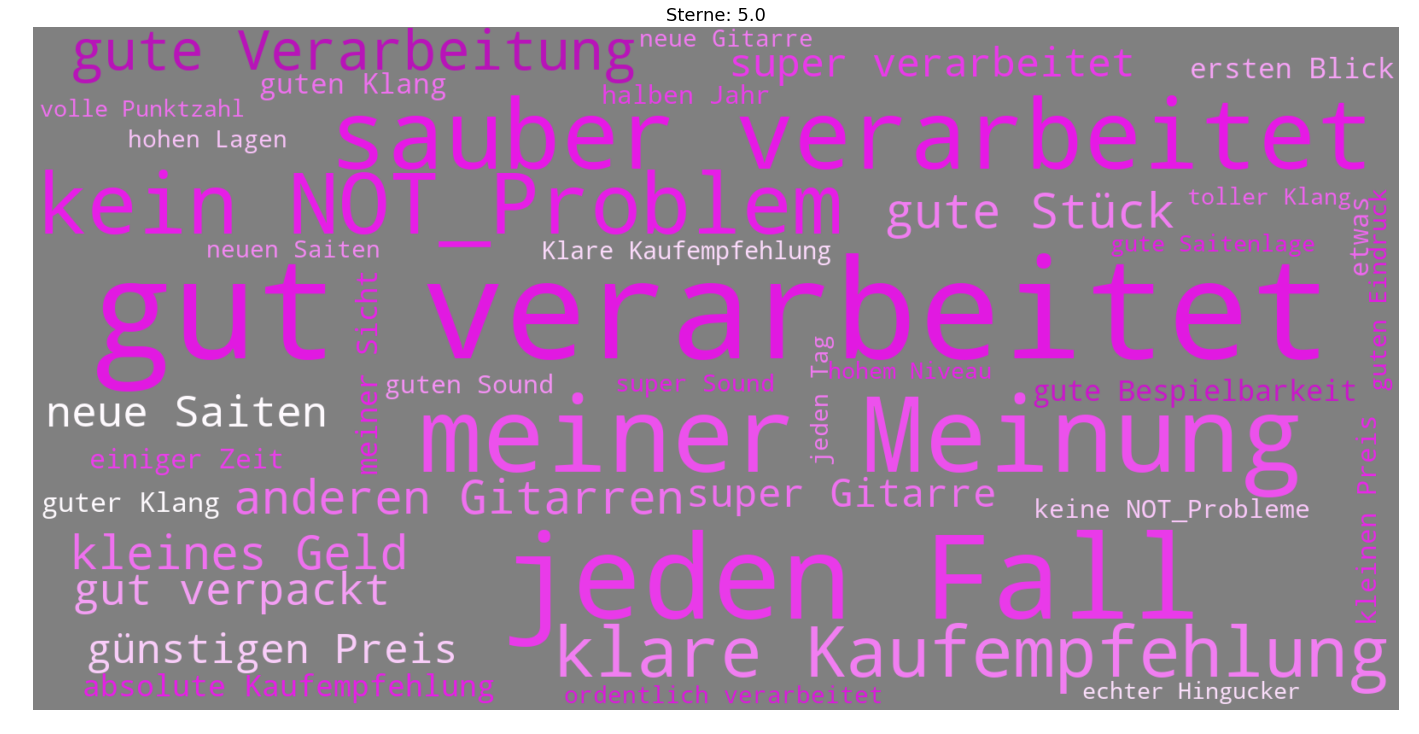

<Figure size 432x288 with 0 Axes>

In [11]:
# erstes Wort = Adjektiv und zweites Wort = Nomen
# je nach Bewertungsklasse
for i in [20,40,60,80,100]:
    create_plots.bigram_wordcould(thomann_data, i, pos1="JJ*",pos2="NN*")

#### Wie wird über die Verarbeiung gesprochen? 

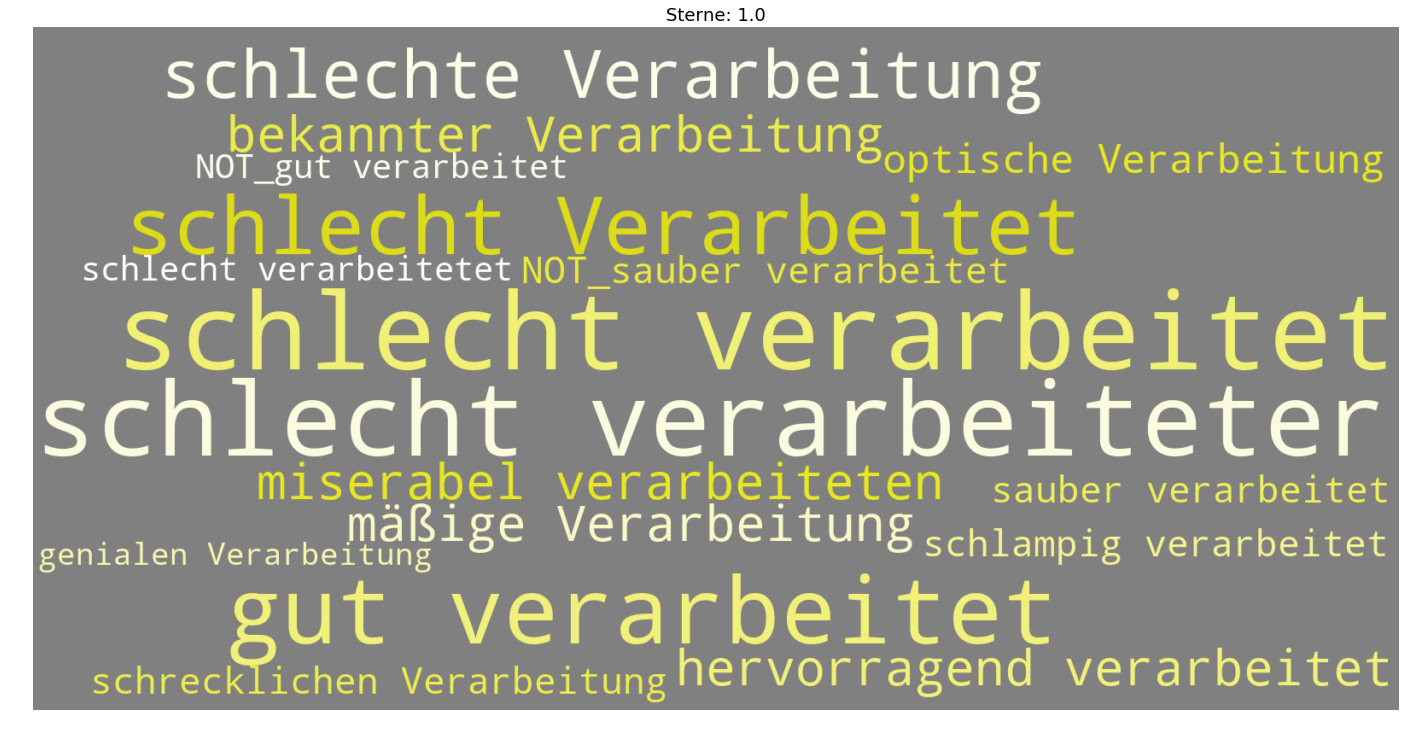

<Figure size 432x288 with 0 Axes>

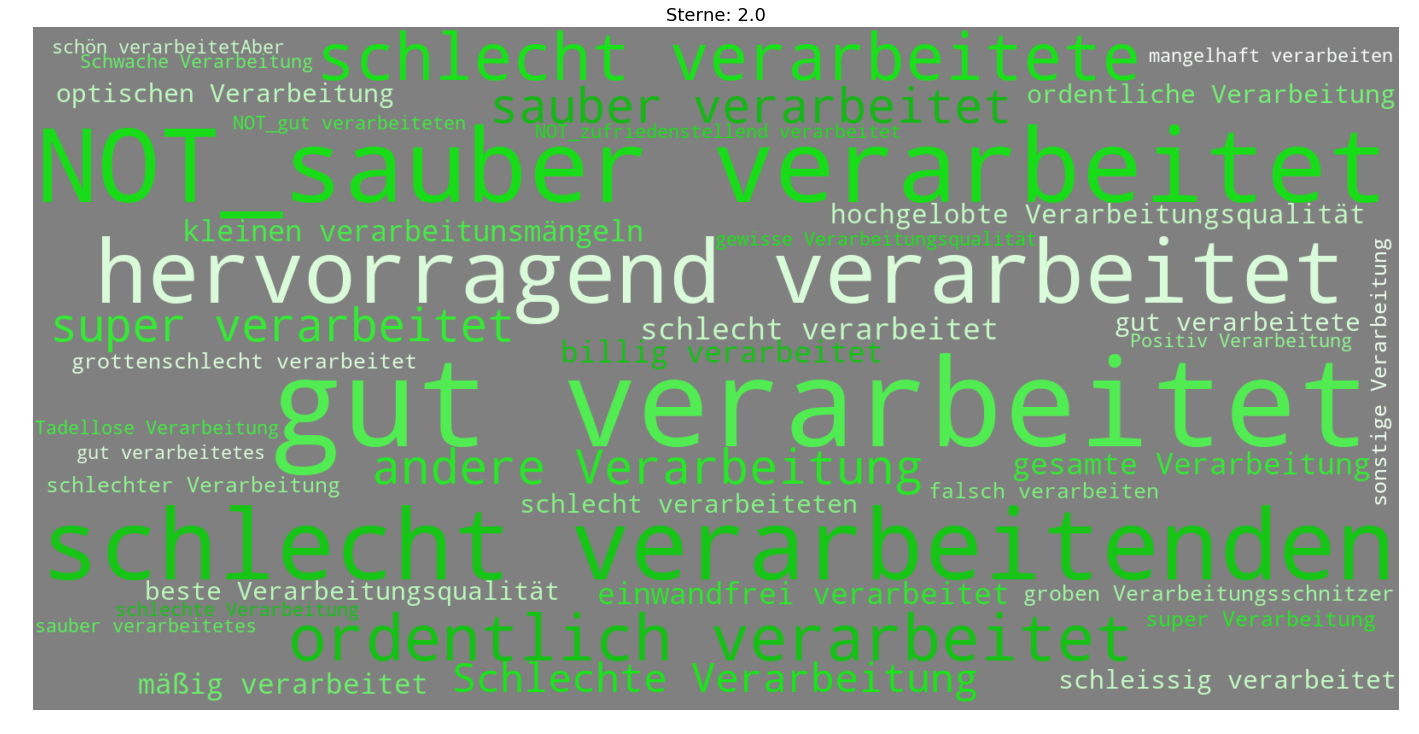

<Figure size 432x288 with 0 Axes>

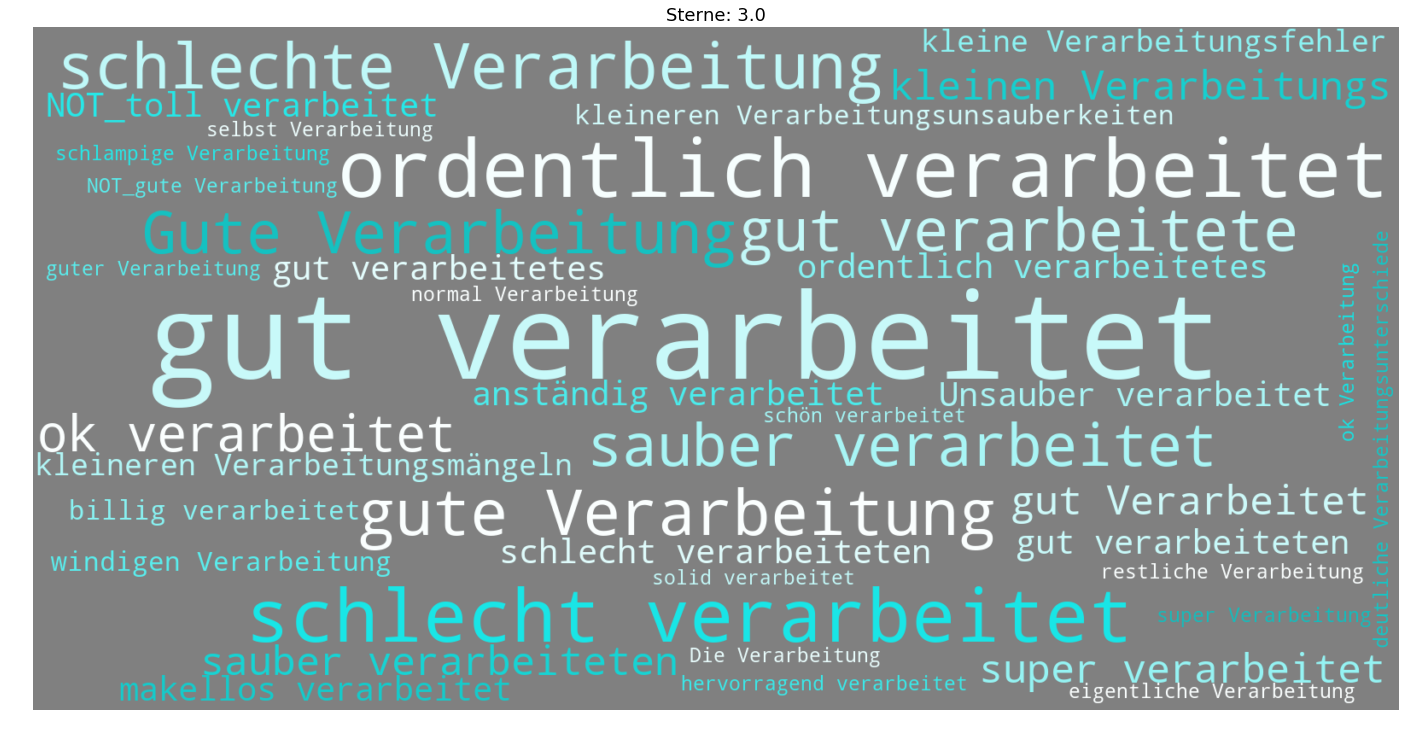

<Figure size 432x288 with 0 Axes>

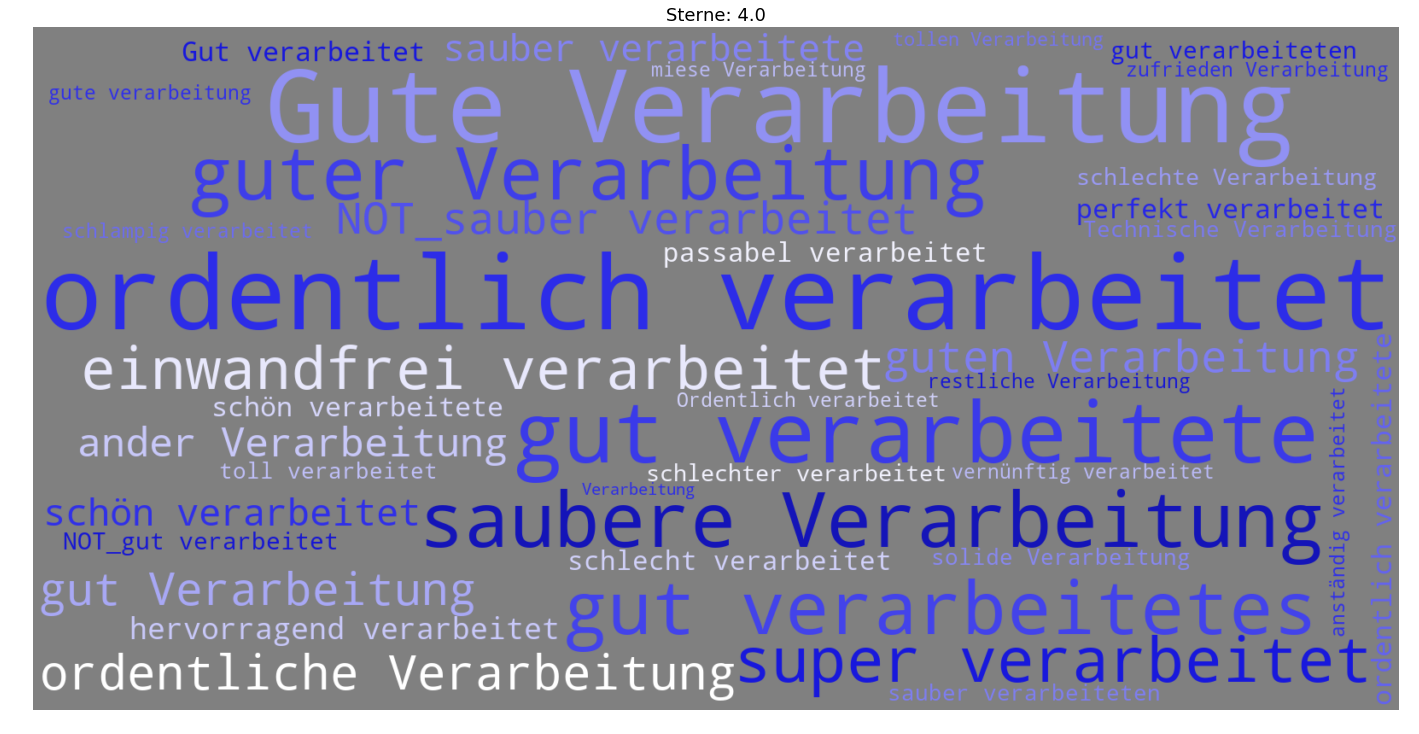

<Figure size 432x288 with 0 Axes>

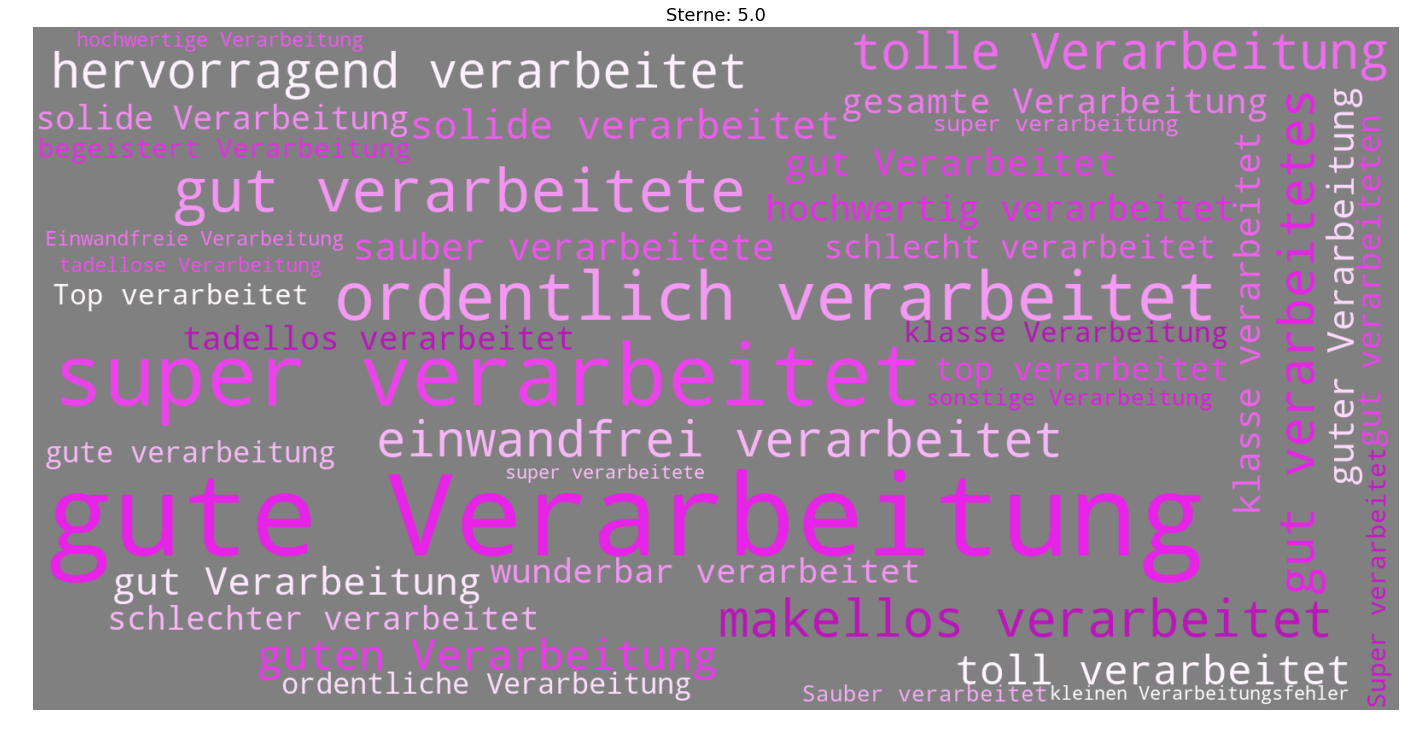

<Figure size 432x288 with 0 Axes>

In [47]:
# gebrauch von verarbeitet je Klasse
for i in [20,40,60,80,100]:
    create_plots.bigram_wordcould(thomann_data, i, pos1="JJ*",word2="[Vv]erarbeit")